In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('Raw Data/P12_S1.csv')
df['UTC'] = pd.to_datetime(df['UTC'], unit='ms')
df = df.sort_values('UTC').reset_index(drop=True)

# Inter-sample deltas in seconds
dt = df['UTC'].diff().dt.total_seconds()

print('Inter-sample Δt (s) stats:')
print(dt.describe())  # look at mean/median vs expected 0.01 s for 100 Hz
print('\nFraction of gaps > 0.02s:', (dt > 0.02).mean())

# Quick check of your existing 3000-sample windows: actual durations
fs = 100
window_size = 30 * fs
stride_size = 10 * fs

durations = []
for start in range(0, len(df) - window_size + 1, stride_size):
    w = df.iloc[start:start+window_size]
    durations.append((w['UTC'].iloc[-1] - w['UTC'].iloc[0]).total_seconds())

durations = pd.Series(durations, name='window_span_seconds')
print('\nActual span of 3000-sample windows (s):')
print(durations.describe())

Inter-sample Δt (s) stats:
count    281990.000000
mean          0.010625
std           0.003474
min           0.004000
25%           0.010000
50%           0.011000
75%           0.011000
max           1.253000
Name: UTC, dtype: float64

Fraction of gaps > 0.02s: 6.02856119521545e-05

Actual span of 3000-sample windows (s):
count    279.000000
mean      31.858265
std        0.120602
min       31.125000
25%       31.815500
50%       31.834000
75%       31.851500
max       32.534000
Name: window_span_seconds, dtype: float64


In [49]:
import pandas as pd

# --- File paths ---
win_path = "Windowed Data/P35_S1_windowed.csv"
rem_path = "Removed Data/P35_S1_windowed_removed.csv"
out_path = "Windowed and Cleaned Data/P35_S1_windowed_interpolated.csv"
log_path = "Interpolation Log/P35_S1_interpolation_log.csv"

# --- Load & parse ---
windowed = pd.read_csv(win_path, parse_dates=["window_start", "window_end"])
removed  = pd.read_csv(rem_path, parse_dates=["window_start", "window_end"])

# 1) keep only rows with a Label
windowed = windowed.dropna(subset=["Label"]).copy()

# 2) flag rows that appear in removed (match on start & end)
key_cols = ["window_start", "window_end"]
windowed = windowed.merge(
    removed[key_cols].assign(_in_removed=True),
    on=key_cols, how="left"
)
windowed["_in_removed"] = windowed["_in_removed"].fillna(False)

# sort by start time
windowed = windowed.sort_values("window_start").reset_index(drop=True)

# convenience masks
mask_removed = windowed["_in_removed"]
mask_keep    = ~mask_removed

interp_records = []
drop_idx = []

for idx in windowed.index[mask_removed]:
    t_r = windowed.at[idx, "window_start"]

    # previous non-removed row
    prev_mask = (windowed["window_start"] < t_r) & mask_keep
    if not prev_mask.any():
        drop_idx.append(idx)  # cannot interpolate (no previous)
        continue
    prev_idx = prev_mask[prev_mask].index[-1]

    # next non-removed row
    next_mask = (windowed["window_start"] > t_r) & mask_keep
    if not next_mask.any():
        drop_idx.append(idx)  # cannot interpolate (no next)
        continue
    next_idx = next_mask[next_mask].index[0]

    t_prev = windowed.at[prev_idx, "window_start"]
    t_next = windowed.at[next_idx, "window_start"]
    hr_prev = windowed.at[prev_idx, "ECG_HR"]
    hr_next = windowed.at[next_idx, "ECG_HR"]

    total_gap = (t_next - t_prev).total_seconds()
    if total_gap <= 0:
        drop_idx.append(idx)  # safety
        continue

    w_prev = (t_next - t_r).total_seconds() / total_gap
    w_next = (t_r - t_prev).total_seconds() / total_gap

    old_hr = windowed.at[idx, "ECG_HR"]
    new_hr = w_prev * hr_prev + w_next * hr_next
    windowed.at[idx, "ECG_HR"] = new_hr

    interp_records.append({
        "row_index": idx,
        "window_start": windowed.at[idx, "window_start"],
        "window_end": windowed.at[idx, "window_end"],
        "old_ECG_HR": old_hr,
        "new_ECG_HR": new_hr,
        "prev_index": prev_idx,
        "prev_time": t_prev,
        "prev_ECG_HR": hr_prev,
        "next_index": next_idx,
        "next_time": t_next,
        "next_ECG_HR": hr_next,
        "weight_prev": w_prev,
        "weight_next": w_next
    })

# drop edge rows that couldn't be interpolated
if drop_idx:
    windowed = windowed.drop(index=drop_idx).reset_index(drop=True)

# clean up and save
windowed = windowed.drop(columns=["_in_removed"])
windowed.to_csv(out_path, index=False)

pd.DataFrame(interp_records).to_csv(log_path, index=False)

print(f"Interpolated {len(interp_records)} rows.")
print(f"Dropped {len(drop_idx)} edge rows with no neighbor on one side.")
print(f"Saved data -> {out_path}")
print(f"Saved log  -> {log_path}")

Interpolated 16 rows.
Dropped 0 edge rows with no neighbor on one side.
Saved data -> Windowed and Cleaned Data/P35_S1_windowed_interpolated.csv
Saved log  -> Interpolation Log/P35_S1_interpolation_log.csv


/var/folders/jf/5xz625d149l3v37wvyxym4hm0000gn/T/ipykernel_2777/108251933.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  windowed["_in_removed"] = windowed["_in_removed"].fillna(False)


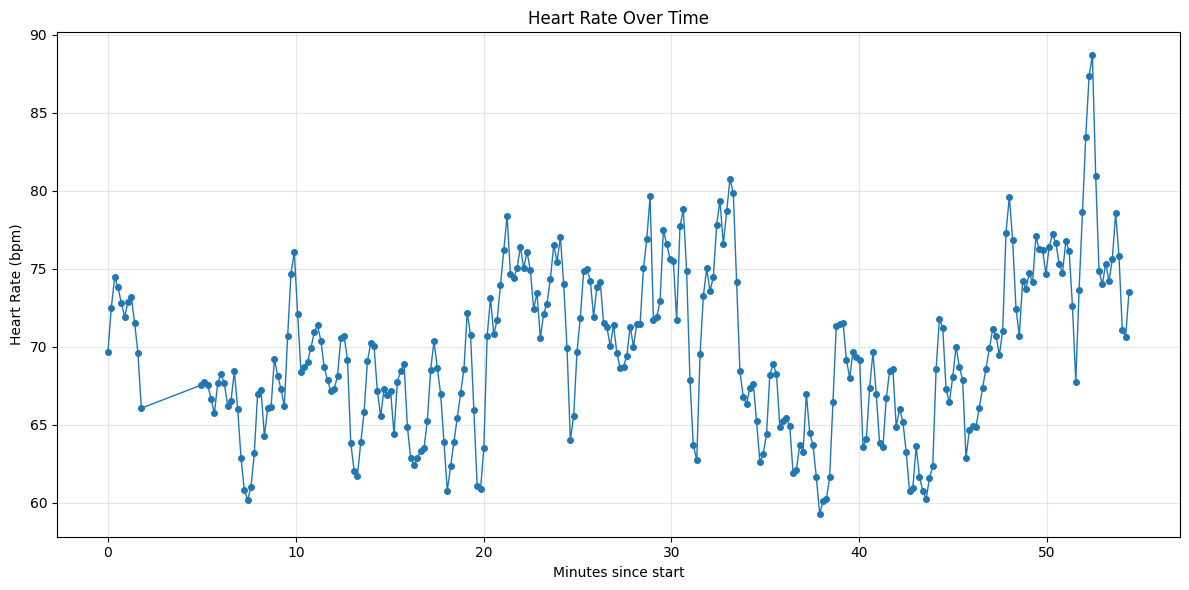

In [50]:
# Plot ECG_HR over time (no thresholds)
import pandas as pd
import matplotlib.pyplot as plt

# --- config ---
csv_path = "Windowed and Cleaned Data/P35_S1_windowed_interpolated.csv"   # change to your file
time_col = "window_start"                # or "window_end"
hr_col = "ECG_HR"
title = "Heart Rate Over Time"

# --- load & prep ---
df = pd.read_csv(csv_path)
df[time_col] = pd.to_datetime(df[time_col])
df = df.sort_values(time_col)
df = df.dropna(subset=[hr_col])

# x-axis as minutes since start (clean, monotonic)
t0 = df[time_col].iloc[0]
x_minutes = (df[time_col] - t0).dt.total_seconds() / 60.0

# --- plot ---
plt.figure(figsize=(12, 6))
plt.plot(x_minutes, df[hr_col], marker='o', linestyle='-', linewidth=1, markersize=4)

plt.title(title)
plt.xlabel("Minutes since start")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# If you want to save the figure instead of (or in addition to) showing it:
plt.savefig("HR_Plots/Post Interpolation/P35.png", dpi=150)
plt.show()